# Simulating Language, Lab 8, Convergence to the Prior

This simulation implements a simplified version of the language model from Kirby, Dowman & Griffiths (2007) using an explicit agent-based simulation.

In [1]:
import random
%matplotlib inline
import matplotlib.pyplot as plt

from math import log, log1p, exp
from scipy.special import logsumexp

from numpy import mean # This is a handy function that calculate the average of a list

## Representing languages

Following Kirby, Dowman & Griffiths (2007), we assume a language is made up of a set of *variables*, each of which can exist in a number of different *variant* forms. This is a rather general characterisation that actually applies well to a number of linguistic phenomena. For example, we can think of the variables as different syntactic categories, and the variants as word orders. Alternatively, the variables could be verb-meanings and the variants different realisations of the past tense, and so on. Agents will produce (and learn from) data which simply exemplifies which variant they have for a particular variable (with the possibility of noise on transmission). 

In this lab, we will group languages into two classes: systematic languages (where the same variant is used for all variables) and unsystematic languages (where more than one variant is used). Note that sometimes in the literature you'll see the words "regular" and "irregular" used instead of systematic/unsystematic but this might be a bit confusing given that we've also looked at regularisation of unpredictable variation in this course.

`all_languages` enumerates all possible languages for expressing variables variables and variants variants using a cute recursive method. Please don't worry too much about how this works! However, you do need to understand what the output of this function means.

In [2]:
def all_languages(n_variables, n_variants):
    """Takes n_variables (number of variables in a language) and n_variants (number of variants of each variable);
       returns list of all possible languages (all possible ways of combining the variants)
       """
    if n_variables == 0:
        return [[]] # The list of all languages with zero variables is just one language, and that's empty
    else:
        result = [] # If we are looking for a list of languages with more than zero variables, 
                    # then we'll need to build a list
        smaller_langs = all_languages(n_variables - 1, n_variants) # Let's first find all the languages with one 
                                                               # fewer variables
        for language in smaller_langs: # For each of these smaller languages, we're going to have to create a more
                                       # complex language by adding each of the possible variants
            for variant in range(n_variants):
                result.append(language + [variant])
        return result

If we run `all_languages(2, 2)` we get all possible languages with two variables and two variants. This is a list that looks like this: `[0, 0], [0, 1], [1, 0], [1, 1]]`. What does this mean exactly? Imagine a bunch of languages that were close to English but had different combinations of ways of making the plural forms for "foot" and "goose":

`[[foots, gooses], [foots, geese], [feet, gooses], [feet, geese]]`

Or if you had different past tense forms for "sing" and "ring":

`[[singed, ringed], [singed, rang], [sang, ringed], [sang, rang]]`

We're using *systematic* here to refer to a language that is systematic in the way it chooses variants for things. The first and last "languages" in each of these four lists is systematic in this sense. "foots" and "gooses" uses an "s" ending for the plural. "feet" and "geese" use the same vowel change, and so on. The others are unsystematic in that they use different ways of expressing the meanings for each meaning. In our simplified numerical notation, the `0` and `1` correspond to "ways of expressing the plural" or "ways of forming the past tense", or really any way in which a language might choose to systematically express something.

Try different numbers of variants and variables in `all_languages` to make sure you understand what these numbers do to our representation of languages.

In [48]:
print(all_languages(3,2))
print(all_languages(2,3))

[[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]
[[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]


*The first argument to the function is the number of variables (we can think of this as the number of different expressions a language has), and the second is the number of variants (i.e. the number of distinct ways each variable/expression can be realised in the language). So, in the first example above, there are 3 different expressions, each of which can be expressed in one of two ways (we can think of this as two different verbs, and there are two possible ways - across all possible languages - that the past tense could be formed). This means each language is a list of three numbers, which can be `0` or `1`. As we have defined it, the completely systematic languages in this list are only `[0, 0, 0]` and `[1, 1, 1]`. In the second example, we are back to only two expressions (so the lists are only two digits long), but each expression can be realised in one of three different possible ways: `0`, `1`, or `2`. In this example, there are three systematic languages: `[0, 0]`,  `[1, 1]`, and `[2, 2]`.*

## Functions for dealing with log probabilities

Here are our standard functions for dealing with logs, as before.

In [3]:
def log_subtract(x,y):
    """Takes two log numbers; returns their difference."""
    return x + log1p(-exp(y - x))

def normalize_logprobs(logprobs):
    """Takes a list of log numbers; returns a list of scaled versions of those numbers that, 
    once converted to probabilities, sum to 1."""
    logtotal = logsumexp(logprobs) #calculates the summed log probabilities
    normedlogs = []
    for logp in logprobs:
        normedlogs.append(logp - logtotal) #normalise - subtracting in the log domain
                                        #equivalent to dividing in the normal domain
    return normedlogs
 
def log_roulette_wheel(normedlogs):
    """Takes a list of normed log probabilities; returns some index of that list 
    with probability corresponding to the (exponentiated) value of that list element"""
    r = log(random.random()) #generate a random number in [0,1), then convert to log
    accumulator = normedlogs[0]
    for i in range(len(normedlogs)):
        if r < accumulator:
            return i
        accumulator = logsumexp([accumulator, normedlogs[i + 1]])

We're also going to have a function that works a little like the `log_roulette_wheel()` but instead always picks the most probable index (instead of picking indices proportional to their probability). We sometimes call this a "winner take all" function. While `log_roulette_wheel()` can be used to implement *sampling*, `wta()` can be used to implement *MAP* hypothesis selection. If there is more than one winner, then we pick randomly among them.

In [4]:
def wta(probs):
    """Takes a list of probabilities (log or normal); returns the index that has the greatest probability."""
    maxprob = max(probs) # Find the maximum probability (works if these are logs or not)
    candidates = []
    for i in range(len(probs)):
        if probs[i] == maxprob:
            candidates.append(i) # Make a list of all the indices with that maximum probability
    return random.choice(candidates)

## Production of data

In [5]:
def produce(language, log_error_probability, n_variants):
    """Takes language (list of variants, represented as numbers), log_error_probability (a number), and n_variants (a number);
       returns variable, variant pair (a 2-tuple of numbers)"""
    variable = random.randrange(len(language)) # Pick a variable to produce
    correct_variant = language[variable]
    if log(random.random()) > log_error_probability:
        return variable, correct_variant # Return the variable, variant pair
    else:
        possible_error_variants = list(range(n_variants))
        possible_error_variants.remove(correct_variant)
        error_variant = random.choice(possible_error_variants)
        return variable, error_variant

The function produce takes a language, selects a random variable, and produces the relevant variant from the language, with a certain probability of error. Can you see how errors on production work?

- Stepping through the code, we first see an if statement which checks some log probabilities to make a decision. Let's ignore their loggyness as they're not important here.
- We check whether `random.random()` - a random number between 0 and 1 - is bigger than (log)`error_probability`, which is usually quite small, say 0.001 for example.
- If `error_probability` is quite small, then `random.random` will almost always be bigger, and in this case the function just returns the intended `variable`/`variant` pair and the function exits.
- In the rare case that it's actually smaller than `error_probability`, then... there's been an error! Then we go into the `else` condition, which will tell us what to do.
- We see that `possible_error_variants` creates a list with the same length as the number of possible `variant`s, and goes on to `remove` the `correct_variant` 
- This means we will pick an `error_variant` which can be anything *except* the intended variant, which makes sense.
- `random.choice` now comes out to play, which simply picks a member of a list at random. In this case, it will pick an `error_variant`, whih can be any of the variants except the intended one.
- Finally, the function exits and returns a pair with the correct `variable` but the *wrong* `variant`, and the sneaky error has entered the system. That's it!*

## Classifying languages

In this language model, prior probability is determined by language class: systematic languages differ from unsystematic languages in their prior probability, and ultimately we are interested in the proportion of our simulated population who use systematic languages. We therefore need a function to take a language and classify it as systematic or not – the function `systematic` does this.

In [6]:
def systematic(language):
    """Takes language (list of variants, represented as numbers);
    returns True if language is systematic, else False"""
    first_variant = language[0]
    for variant in language:
        if variant != first_variant:
            return False # The language can only be systematic if every variant is the same as the first
    return True

* The purpose of this function is to check whether a particular language is systematic or not. The function uses the fact that we know that, in a completely systematic language, every `variable` must be the same type of `variant`. 
* So all we need to do here is check that every item in the list is the same type, i.e. just a list of the same value repeated every time. 
* There are a lot of ways that we *could* do this, but the one used here is sensible: 
    * `first_variant` records the value of the first item in the `language` list by checking index `0`
    * The for loop sets up a check for every `variant` in the `language` list
    * If at any point the `variant` being checked is not the same as `first_variant`, that means that the language has more than one value in it.
    * In code language, if `variant != first_variant`, then we immediately know that the language is not systematic, and can exit with an authoritative `False`, as there is no need to check any more items.
    * On the other hand, if we manage to get all the way to the end of the list without finding any non-conformist variants, we finish the for loop knowing that the language must be systematic, and can exit with `True`, hurrah

## The Bayesian bits

In [7]:
def logprior(language, log_bias, n_variables, n_variants):
    """Takes language (list of variants, represented as numbers), log_bias 
    (log probability representing strength of preference for systematic languages),
    the number of possible variables, and the number of possible variants;
    returns a number, the log prior probability of the given language."""
    if systematic(language):
        number_of_systematic_languages = n_variants
        return log_bias - log(number_of_systematic_languages) #subtracting logs = dividing
    else:
        number_of_unsystematic_languages = n_variants ** n_variables - n_variants # the double star here means raise to the power
                                                                         # e.g. 4 ** 2 is four squared
        return log_subtract(0, log_bias) - log(number_of_unsystematic_languages)
        # log(1) is 0, so log_subtract(0, bias) is equivalent to (1 - bias) in the
        # non-log domain

The function `logprior` returns the prior probability (as a log probability) of a particular language. The strength of preference for systematic languages is given as the second argument – if bias is over 0.5 (when converted back from a log probability), systematic languages have higher prior probability.

* We know that a systematic language is just a repeated list of the same value.
* This means there is only one possible systematic language for each variant: if languages are represented by a list of 5 variants, and the only variants are `0` and `1`, then the possible systematic languages would be `[0,0,0,0,0]` and `[1,1,1,1,1]`.
* So the number of possible systematic languages is just the same as the number of variants, as we see in `number_of_systematic_languages = variants`
* How many *unsystematic* languages are there? Well, first we can calculate the total number of possible languages overall...
* This is just like counting outcomes of a coin-flip or a dice-roll: the number of possibilities for the first variable (coin-flip/dice-roll), times the number of possibilities for the second, times etc etc
* So say languages are represented by 5 `variable`s, and there are 3 `variant`s, the total number of possible languages is `3 * 3 * 3 * 3 * 3`
* A quicker way of writing that is $3^5$, or in Python `3**5`
* So the total number of possible langages is `variants ** variables`
* BUT: that includes all systematic **and** unsystematic languages.
* But since we know that the number of *systematic* languages is just the same as the number of `variants`, we can just subtract that from the total number, hence `number_of_unsystematic_languages = variants ** variables - variants`

- Why are we dividing the bias by the number of systematic and unsystematic languages in this function? Check you understand how these numbers are calculated.
- How does this function differ from the prior from the Kirby, Dowman & Griffiths (2007) paper? (Hint: consider the case of more than two variables.)

1. * First, it's important to know that this function calculates the prior probability of a *particular* language
    * Second, `log_bias` is the *overall* bias of a system towards systematic languages *in general*, i.e. not a particular systematic language but *all* of them lumped together.
    * This means that all of the prior probability which is allocated towards systematic languages, `log_bias`, needs to be split between them.
    * So, to calculate the bias towards any *particular* systematic language, we need to spread the total systematicity bias equally between them.
    * So, when we divide `log_bias` by the number of systematic langugages, we're just sharing the total *general* bias for systematic languages between the actual *particular* ones, that's all.
    * Oh no its a log! Don't worry, remember that logs are our friends, and subtracting in logworld is the same as dividing normal numbers.
    * But what about unsystematic languages? Well, if the bias towards systematic languages *overall*, *in general*, is $bias$, then the bias towards *unsystematic* languages must be $1 -bias$.
    * Oh dear, it's the dreaded logs again - what do we do with `log_bias`? Don't worry, all `log_subtract(0, log_bias)` is doing is $1 - bias$ but off in logland (if you're worried about why it's using `0` and not `1`, it's because $log(1) = 0$, but just don't worry anyway).
    * Finally, the `- log(number_of_unsystematic_languages)` bit is just doing the same thing as above, i.e. sharing out the general bias – but this time towards unsystematic, not systematic languages, evenly across all the possible unsystematic languages.
    
2. The prior in the Kirby, Dowman & Griffiths paper is a lot fancier, but put simply, it measures *how* systematic/unsystematic languages are, and the systematicity bias then applies differently to specific languages depending on how systematic they are. So, for example, if there is a strong bias for systematicity, it will result in a strong bias for not just the completely systematic languages, but also quite a strong preference for the *almost* systematic languages; equally, it would have a very strong preference against maximally unsystematic languages (i.e. with equal numbers of each variant), and a little less strong for the slightly less unsystematic ones.

In [8]:
def loglikelihood(data, language, log_error_probability, n_variants):
    """Takes data (list of utterances represented as variable, variant pairs),
    language (list of variants, represented as numbers),
    log_error_probability, and number of variants; returns log likelihood of data given this languageg"""
    loglikelihoods = []
    logp_correct = log_subtract(0, log_error_probability) #logprob of producing correct form
    logp_incorrect = log_error_probability - log(n_variants - 1) #logprob of each incorrect variant
    for utterance in data:
        variable = utterance[0]
        variant = utterance[1]
        if variant == language[variable]:
            loglikelihoods.append(logp_correct)
        else:
            loglikelihoods.append(logp_incorrect)
    return sum(loglikelihoods) #summing log likelihoods = multiplying likelihoods

The function `loglikelihood` takes a language and a list of data and works out the (log) likelihood of the data given the language. We allows some small probability (given by the third argument) that a speaker will produce the ‘wrong’ variant, i.e. a variant other than that specified by their language.

## Learning

Bayesian learners calculate the posterior probability of each language based on some data, then select a language (‘learn’) based on those posterior probabilities. `learn` implements this. As discussed in the lecture, there are two ways you could select a language based on the posterior probability distribution:
- You could pick the best language – i.e. the language with the highest posterior probability. This is called MAP (“maximum a posteriori”) learning.
- Alternatively, you could pick a language probabilistically based on its posterior probability, without necessarily going for the best one every time (e.g. if language 0 has twice the posterior probability of language 1, you are twice as likely to pick it). This is called sampling (for “sampling from the posterior distribution”).

The `learn` function implements both these ways of learning, using the `wta` function to do MAP learning and using `log_roulette_wheel` to do sampling (from previous labs, which assumed learners sample from the posterior).

In [9]:
def learn(data, log_bias, log_error_probability, learning_type, n_variables, n_variants):
    """
    Takes:
        data: list of utterances represented as variable, variant pairs
        log_bias: log probability representing overall bias of a system toward systematic languages
        log_error_probability: log probability of producing wrong variant
        learning_type: either "map" or "sample"
        n_variables: number of possible variables
        n_variants: number of possible variants
    Returns:
        sampled language: A language (list of variants), chosen based on learning_type
    """
    list_of_all_languages = all_languages(n_variables, n_variants)
    list_of_posteriors = []
    for language in list_of_all_languages:
        this_language_posterior = loglikelihood(data, language, 
                                                log_error_probability,
                                                n_variants) + logprior(language, log_bias, 
                                                                      n_variables, 
                                                                      n_variants)
        list_of_posteriors.append(this_language_posterior)
    if learning_type == 'map':
        map_language_index = wta(list_of_posteriors) # For MAP learning, we pick the best language
        map_language = list_of_all_languages[map_language_index]
        return map_language
    if learning_type == 'sample':
        normalized_posteriors = normalize_logprobs(list_of_posteriors)
        sampled_language_index = log_roulette_wheel(normalized_posteriors) # For sampling, we use the roulette wheel
        sampled_language = list_of_all_languages[sampled_language_index]
        return sampled_language

## Iterated learning

`iterate()` is the top-level function which actually runs the simulation. It starts with a random language from the set of possible languages, and then each generation a learner learns from data produced by the previous agent. This function returns a list indicating whether the language is systematic or not each generation. For convenience we encode the systematic languages as `1` in this list and `0` otherwise. It also returns a second list, showing what each language was per generation in case you want more details. (Generally, we're just going to be using the first list for plotting graphs etc.)

In [10]:
def iterate(generations, bottleneck, log_bias, log_error_probability, learning_type,
           n_variables, n_variants):
    """
    Takes:
        generations: number of generations to run the simulation for.
        bottleneck: number of utterances to produce in each generation.
        log_bias: log probability representing overall bias of a system toward systematic languages
        log_error_probability: log probability of producing wrong variant
        learning_type: either "map" or "sample"
        n_variables: number of possible variables
        n_variants: number of possible variants
    Returns: 
        accumulator: list of 0s and 1s (systematicity), one for each generation
        language_accumulator: list of languages (themselves lists of variants).
    """
    # Randomly choose a starting language and record whether or not it's systematic.
    language = random.choice(all_languages(n_variables, n_variants))
    if systematic(language):
        accumulator = [1]
    else:
        accumulator = [0]
    language_accumulator = [language]

    # Iterate over generations.
    for generation in range(generations):
        data = []
        for i in range(bottleneck):
            data.append(produce(language, log_error_probability, n_variants))
        language = learn(data, log_bias, log_error_probability, learning_type, 
                         n_variables, n_variants)
        if systematic(language):
            accumulator.append(1)
        else:
            accumulator.append(0)
        language_accumulator.append(language)

    return accumulator, language_accumulator

So, for example, to do an iterated learning simulation for 10 generations, a bottleneck of 5, with a bias in favour of systematicity of 0.6, an error probability of 0.05, with sampling as the learning type, 2 variables, and 2 variants, you'd use:

```
iterate(10, 5, log(0.6), log(0.05), 'sample', 2, 2)
```

## Questions

**Note:** To answer some of these questions, you're going to have to run quite long simulation runs (up to 100000 generations to get super accurate results). In general, you probably want to keep the bottleneck values between 1 and 10.

1. Using the default parameters suggested above, can you demonstrate convergence to the prior? You may want to start with a line graph of the results to get a sense of what's going on in the simulation. You could also plot a histogram to get the overall proportion of systematic languages in the whole run, but notice that this is just the same as the average of your whole list so you don't really need a graph for this! You can get the average directly by using, for example, `print(mean(data[0]))` if `data` is the result of your simulation run (remember the `iterate()` function returns whether the language at the each generation is systematic or not as the first part of the data it returns, which is why we use `data[0]`.

*Let's start out using a bottleneck of 5 and run a bunch of runs and make a line plot of them all on the same graph.*

Text(0, 0.5, 'systematicity')

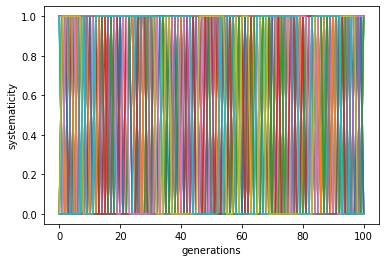

In [19]:
for i in range(100):
    data = iterate(100, 5, log(0.6), log(0.05), 'sample', 2, 2)
    plt.plot(data[0])

plt.xlabel("generations")
plt.ylabel("systematicity")

*Hmmm... that's not very useful, is it? The lines are going back and forth between 0 and 1 so much that we can't recognise any patterns. Let's do a histogram of one run instead!*

Text(0.5, 0, 'systematicity')

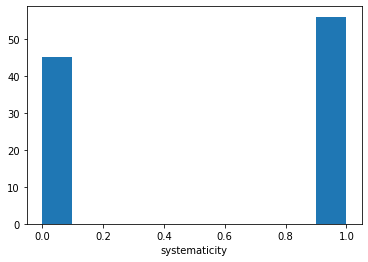

In [20]:
data = iterate(100, 5, log(0.6), log(0.05), 'sample', 2, 2)
plt.hist(data[0])
plt.xlabel("systematicity")

*Ok, that seems a bit more informative. Notice that it does look like the prior bias is reflected here – it's 0.6 by default, so we'd expect approximately 60 of our 100 generations should be systematic. But it's a bit of a silly graph. It's really only reflecting a single number (the proportion of 1's in the list). So let's just find out the mean instead.*

In [21]:
print(mean(data[0]))

0.5544554455445545


*This doesn't look quite right. Maybe we need to run the simulation for longer?*

In [24]:
data = iterate(10000, 5, log(0.6), log(0.05), 'sample', 2, 2)
print(mean(data[0]))

0.601939806019398


*OK, that's better! Now we can try some different values for the prior. Remember that the prior is given as a log.*

In [26]:
biases = [0.2, 0.4, 0.6, 0.8]
for bias in biases:
    print(bias, mean(iterate(10000, 5, log(bias), log(0.05), 'sample', 2, 2)[0]))

0.2 0.1987801219878012
0.4 0.41015898410158985
0.6 0.6013398660133986
0.8 0.7938206179382061


*It looks like the average of a long run is close to the prior.*

2. How does changing the error rate and bottleneck size affect the results for the sample learner? Make sure you run the simulation long enough to get repeatable results.

In [27]:
errors = [0.0005, 0.005, 0.05, 0.5]
for error in errors:
    print(error, mean(iterate(10000, 5, log(0.6), log(error), 'sample', 2, 2)[0]))

0.0005 0.5576442355764424
0.005 0.601939806019398
0.05 0.5934406559344065
0.5 0.6031396860313969


*Our convergence to the prior result appears to be unaffected by errors. That's a bit odd. It seems like it really doesn't matter what the speaker is saying! Let's try that with different bottleneck sizes too...*

In [28]:
bottlenecks = range(1,11)
for bottleneck in bottlenecks:
    print(bottleneck, mean(iterate(10000, bottleneck, log(0.6), log(0.05), 'sample', 2, 2)[0]))

1 0.5968403159684031
2 0.5996400359964004
3 0.6046395360463953
4 0.6042395760423958
5 0.6182381761823817
6 0.5748425157484252
7 0.5767423257674232
8 0.5683431656834317
9 0.6293370662933707
10 0.654934506549345


*Just like with the error term, the size of the bottleneck seems to be irrelevant for the convergence result! Are they doing anything at all? Let's look at indivdual runs instead...*

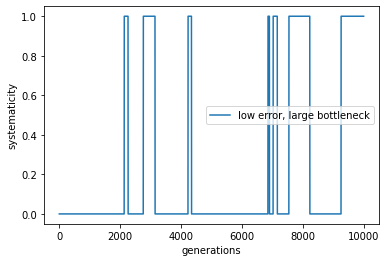

In [35]:
plt.plot(iterate(10000, 10, log(0.6), log(0.0005), 'sample', 2, 2)[0], 
         label='low error, large bottleneck')
plt.xlabel('generations')
plt.ylabel('systematicity')
plt.legend()

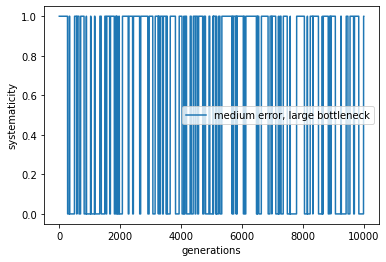

In [36]:
plt.plot(iterate(10000, 10, log(0.6), log(0.05), 'sample', 2, 2)[0], 
         label='medium error, large bottleneck')
plt.xlabel('generations')
plt.ylabel('systematicity')
plt.legend()

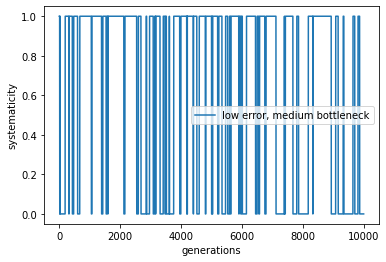

In [37]:
plt.plot(iterate(10000, 7, log(0.6), log(0.005), 'sample', 2, 2)[0], 
         label='low error, medium bottleneck')
plt.xlabel('generations')
plt.ylabel('systematicity')
plt.legend()

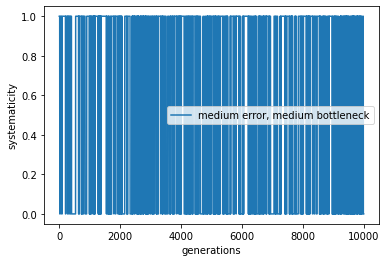

In [38]:
plt.plot(iterate(10000, 7, log(0.6), log(0.05), 'sample', 2, 2)[0], 
         label='medium error, medium bottleneck')
plt.xlabel('generations')
plt.ylabel('systematicity')
plt.legend()

*What these results show is that although the iterated learning chain spends the same proportion of time in the set of systematic languages across all these different parameter settings and this is determined only by the prior bias (which is what we mean by "convergence to the prior"), the other parameters change how quickly the language changes from one state to another.*

3. Switch the learning type to MAP learning, and rerun the simulation. Can you show the amplification of prior bias that is shown in the paper?

In [39]:
biases = [0.2, 0.4, 0.6, 0.8]
for bias in biases:
    print(bias, mean(iterate(10000, 5, log(bias), log(0.05), 'map', 2, 2)[0]))

0.2 0.1284871512848715
0.4 0.12038796120387961
0.6 0.879012098790121
0.8 0.8649135086491351


*This looks like amplification of the prior bias. For biases in favour of systematic languages (i.e. over 0.5), we get **more** systematic languages than we would expect. For biases favouring the unsystematic languages, we get **fewer** systematic languages than we would expect.*

4. How is bias amplification affected by the bottleneck size? Can you run a range of simulations for different bottleneck sizes, find the means, and plot these nicely in a graph?

*I'm going to try this with longer runs, because the numbers above look a bit messy to me, so maybe we need a longer run to get a more accurate reading of the proportions.*

In [40]:
results = []
bottlenecks = range(1,11)
for bottleneck in bottlenecks:
    results.append(mean(iterate(100000, bottleneck, log(0.6), log(0.05), 'map', 2, 2)[0]))

*Notice that I've got a separate cell for running the simulation and plotting the results. That's because it's taking several minutes to run the simulations now, and I don't want to have to redo them every time I want to tweak my graph!*

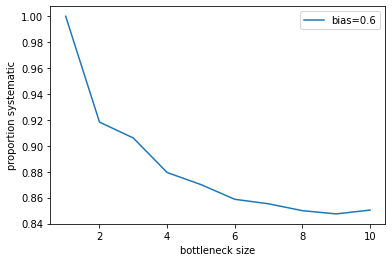

In [41]:
plt.plot(range(1, 11), results, label="bias=0.6")
plt.xlabel("bottleneck size")
plt.ylabel("proportion systematic")
plt.legend()

*We're clearly seeing bias amplifcation (all these numbers are higher than 0.6), and it's affected by the bottleneck (tighter bottlenecks lead to more amplification). Let's try different priors (this really does take a while to run).*

In [42]:
biases = [0.2, 0.4, 0.6, 0.8]
all_results = []
for bias in biases:
    results = []
    for bottleneck in range(1, 11):
        results.append(mean(iterate(100000, bottleneck, log(bias), log(0.05), 'map', 2, 2)[0]))
    all_results.append(results)

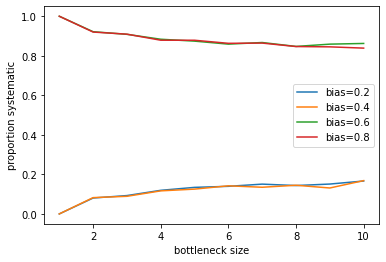

In [43]:
for i in range(len(all_results)):
    plt.plot(range(1, 11), all_results[i], 
             label="bias=" + str(biases[i])) # trick to convert number to a string
    
plt.xlabel("bottleneck size")
plt.ylabel("proportion systematic")
plt.legend()

*Well, look at that! This is almost the opposite of the result for samplers. Now, **the strength of the bias doesn't matter** – just which side of 0.5 it is, and as we saw about the size of the bottleneck **does** matter... Just for completeness, let's add the results for samplers just to make it super clear! I'm also going to take a bit more care with colours so the graph is a bit more readable.*

*N.B. This simulation is very slow, I assume because there's a lot more maths involved in doing the roulette wheel compared to just picking the best. To stop myself getting bored waiting, I put a print in the loop so I had something to watch...*

In [44]:
biases = [0.2, 0.4, 0.6, 0.8]
all_results2 = []
for b in biases:
    results = []
    bias = b
    for bottleneck in range(1, 11):
        print(b, bottleneck)
        results.append(mean(iterate(100000, bottleneck, log(bias), log(0.05), 'sample', 2, 2)[0]))
    all_results2.append(results)

0.2 1
0.2 2
0.2 3
0.2 4
0.2 5
0.2 6
0.2 7
0.2 8
0.2 9
0.2 10
0.4 1
0.4 2
0.4 3
0.4 4
0.4 5
0.4 6
0.4 7
0.4 8
0.4 9
0.4 10
0.6 1
0.6 2
0.6 3
0.6 4
0.6 5
0.6 6
0.6 7
0.6 8
0.6 9
0.6 10
0.8 1
0.8 2
0.8 3
0.8 4
0.8 5
0.8 6
0.8 7
0.8 8
0.8 9
0.8 10


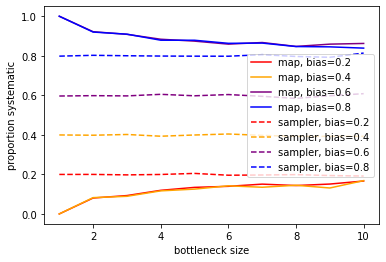

In [45]:
colours = ['red', 'orange', 'purple', 'blue']

for i in range(len(all_results)):
    plt.plot(range(1, 11), all_results[i], color = colours[i],
             label="map, bias=" + str(biases[i]))
    
for i in range(len(all_results2)):
    plt.plot(range(1, 11), all_results2[i], color = colours[i], linestyle='dashed',
             label="sampler, bias=" + str(biases[i]))
    
plt.xlabel("bottleneck size")
plt.ylabel("proportion systematic")
plt.legend()